In [5]:
import numpy as np

filename = "./resampled_data_.npz"
npzfile = np.load(filename)
print(npzfile.files)

target_data = npzfile['arr_0']
non_target_data = npzfile['arr_1']

print("Target data shape: ", target_data.shape)
print("Non-target data shape: ", non_target_data.shape)


['arr_0', 'arr_1']
Target data shape:  (8250, 7, 300)
Non-target data shape:  (41250, 7, 300)


In [6]:
file2 = "./resampled_dataBIO_dsi.npz"
npzfile2 = np.load(file2)
print(npzfile2.files)

test_data = npzfile2['arr_0']
non_test_data = npzfile2['arr_1']

print("Target data shape: ", test_data.shape)
print("Non-target data shape: ", non_test_data.shape)



['arr_0', 'arr_1']
Target data shape:  (210, 7, 300)
Non-target data shape:  (1260, 7, 300)


In [7]:
from sklearn.model_selection import train_test_split

X_train = np.concatenate([target_data, non_target_data])
y_train = np.concatenate([np.ones(target_data.shape[0]), np.zeros(non_target_data.shape[0])])
X_test = np.concatenate([test_data, non_test_data])
y_test = np.concatenate([np.ones(test_data.shape[0]), np.zeros(non_test_data.shape[0])])

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print(X_train[0, 0, :])
print("\nX_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_test[0, 0, :])

X_train shape:  (49500, 7, 300)
Y_train shape:  (49500,)
[  8.14300371  14.16771235  12.33219501  13.10044693  11.836693
  12.23011571  11.87630586  12.63155056  12.45622913  12.50851965
  11.56145959  10.98507812  10.14562023  10.06235404   9.85316618
  10.04981114   9.92710403  10.19779207  10.43643363  11.11708587
  11.55654928  11.91730858  11.5961198   11.00505532  10.04321432
   9.39454815   8.95863564   9.02577939   9.19247216   9.56808874
   9.72418419   9.74923616   9.44121477   9.14247391   8.77687375
   8.53252291   8.12869592   7.60629527   6.82277165   6.02713397
   5.21095363   4.61352667   4.15101571   3.87092667   3.60406847
   3.41471528   3.22733647   3.20076351   3.3585255    3.81440645
   4.48454221   5.34823613   6.17918308   6.81002517   7.09641632
   7.20785449   7.32520896   7.57805785   7.93349252   8.42126735
   9.07603173   9.93620801  10.92057788  11.87034557  12.54149041
  12.70653157  12.2796427   11.33723525  10.06600971   8.66355497
   7.38570138   6.434

In [8]:
import warnings
import torch
import random
warnings.filterwarnings("ignore")

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(777)

In [9]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv2d(1, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        conv2 = nn.Conv2d(3, 6, 3, 1, padding=True)
        max_pool = nn.MaxPool2d(2)
        
        fc1 = nn.Linear(3*1*75, 2) # fully connected layer 1번 
        #out = nn.Linear(32, 2) #out put layer 
        
        # Batch x Channel x Height x Width
        self.conv = nn.Sequential(
            conv1,  # N x 1 x 7 x 300 -> N x 3 x 7 x 300
            nn.ReLU(),
            max_pool,  # N x 3 x 7 x 300 -> N x 3 x 3 x 150
            max_pool, # N x 3 x 3 x 150 -> N x 3 x 1 x 75
            #conv2,  # N x 6 x 3 x 150 -> N x 16 x 3 x 150
            #nn.ReLU(),
            #max_pool,  # N x 16 x 3 x 150 -> N x 16 x 1 x 75
        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            #nn.ReLU(),# activate function 이걸 뺀것
            #out,  # N x 32 -> N x 2 이걸 뺀것 
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x

In [10]:
from EEGDataset import EEGDataset
from torch.utils.data import DataLoader
import torch

batch_size = 4

train_loader = DataLoader(
                EEGDataset(X_train, y_train), 
                batch_size=batch_size, 
                shuffle=True)

test_loader = DataLoader(
                EEGDataset(X_test, y_test),
                batch_size=batch_size,
                shuffle=False)

In [11]:
import torch
import torch.nn as nn
from torch import optim

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-4
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr) # Adam optimizer -->내려가는 방법 생각해보기 == lr learning mate 적절하게 하면 좋다. adam 은 0.001 줄여보면서 
epochs = 2

In [12]:
from sklearn.metrics import accuracy_score

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

num_batches = len(train_loader)

for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    for i, data in enumerate(train_loader):
        """ 
        이번 학습에 사용될 데이터를 Batch 단위로 불러옵니다.
        우리는 이전에 batch_size를 4로 설정했으므로, 4개의 데이터가 불러와집니다.
        """

        data, label = data['data'].float().to(DEVICE), data['labels'].float().to(DEVICE)
        
        """
        optimizer.zero_grad(): 함수를 사용하여 기존에 남아있던 gradient를 모두 제거해줍니다.
        이는 이전 데이터가 새로 학습될 데이터에 영향을 끼치는 것을 막아줍니다.
        
        output = model(data): CNN 모델에 학습 데이터를 넣고 결과를 만들어냅니다.
        
        loss = criterion(output, label): 모델이 만들어낸 결과와, 실제 정답간의 차이를 이용해서 오차 값을 만들어 냅니다.
        추후에 이 값을 이용하여 모델이 학습을 하게 됩니다.
        
        loss.backward(): 위에서 만들어낸 오차 값을 각 노드에게 전파하여 각 노드가 업데이트 해야 할 오차가 얼마인지 찾아냅니다.
        
        optimizer.stop(): 각 노드별로 받은 오차를 가지고 optimizer의 방법 (여기서는 Adam)을 기반으로 weight를 업데이트 합니다.
        """
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # Visualization을 위해 loss값과 accuracy를 저장합니다.
        train_loss += loss.item()
        train_acc += accuracy_score(np.argmax(label.cpu().detach().numpy(), axis=1), np.argmax(output.cpu().detach().numpy(), axis=1))
        
        """
        10번의 batch마다 test를 진행합니다.
        모델을 test할 때는 weight를 업데이트 시키면 안되기 때문에 torch.no_grad()를 이용합니다.
        """
        if (i + 1) % 100 == 0:
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                for j, test_data in enumerate(test_loader):
                    test_data, test_label = test_data['data'].float().to(DEVICE), test_data['labels'].float().to(DEVICE)
                    test_output = model(test_data)
                    loss = criterion(test_output, test_label)
                    test_loss += loss.item()
                    test_acc += accuracy_score(np.argmax(test_label.cpu().detach().numpy(), axis=1), np.argmax(test_output.cpu().detach().numpy(), axis=1))
            
            print('epoch: {}/{} | step: {}/{} | train_loss: {:.4f} | test_loss: {:.4f} | acc: {:.4f}'.format(
                epoch + 1, epochs, i + 1, num_batches, train_loss / 100, test_loss / len(test_loader), test_acc / len(test_loader)
            ))
            
            train_loss_list.append(train_loss / 100)
            train_acc_list.append(train_acc / 100)
            test_loss_list.append(test_loss / len(test_loader))
            test_acc_list.append(test_acc / len(test_loader))
            train_loss = 0
            train_acc = 0

epoch: 1/2 | step: 100/12375 | train_loss: 1.0139 | test_loss: 0.6223 | acc: 0.6793
epoch: 1/2 | step: 200/12375 | train_loss: 0.8632 | test_loss: 0.6294 | acc: 0.6712
epoch: 1/2 | step: 300/12375 | train_loss: 0.7751 | test_loss: 0.6414 | acc: 0.6501
epoch: 1/2 | step: 400/12375 | train_loss: 0.7381 | test_loss: 0.6396 | acc: 0.6590
epoch: 1/2 | step: 500/12375 | train_loss: 1.0140 | test_loss: 0.6538 | acc: 0.6298
epoch: 1/2 | step: 600/12375 | train_loss: 0.7892 | test_loss: 0.6747 | acc: 0.5740
epoch: 1/2 | step: 700/12375 | train_loss: 0.6586 | test_loss: 0.6420 | acc: 0.6590
epoch: 1/2 | step: 800/12375 | train_loss: 0.6942 | test_loss: 0.6572 | acc: 0.6257
epoch: 1/2 | step: 900/12375 | train_loss: 0.8320 | test_loss: 0.6494 | acc: 0.6447
epoch: 1/2 | step: 1000/12375 | train_loss: 0.7671 | test_loss: 0.6808 | acc: 0.5537
epoch: 1/2 | step: 1100/12375 | train_loss: 0.7616 | test_loss: 0.6599 | acc: 0.6223
epoch: 1/2 | step: 1200/12375 | train_loss: 0.8351 | test_loss: 0.6839 | a

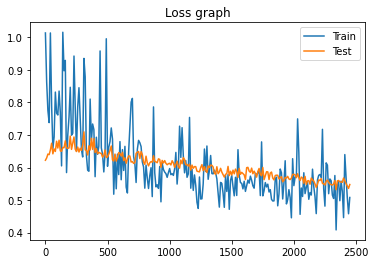

In [15]:
import matplotlib.pyplot as plt

x_tick = np.arange(0, len(train_loss_list) * 10, 10)
plt.title('Loss graph')
plt.plot(x_tick, train_loss_list, label='Train')
plt.plot(x_tick, test_loss_list, label='Test')
plt.legend()

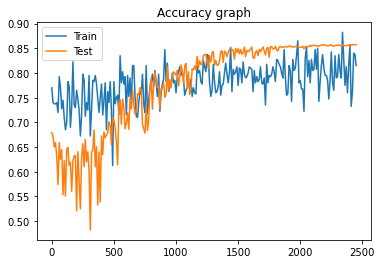

In [14]:
x_tick = np.arange(0, len(train_acc_list) * 10, 10)
plt.title('Accuracy graph')
plt.plot(x_tick, train_acc_list, label='Train')
plt.plot(x_tick, test_acc_list, label='Test')
plt.legend()

In [16]:
model_save='D:/P300_biosemi_55/Model/ZERO.pt'
model_save_weights='D:/P300_biosemi_55/Model/weight/ZERO_Weight.pt'

torch.save(model, model_save)
torch.save(model.state_dict(), model_save_weights)
model.eval()

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=225, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)

In [32]:
import numpy as np

filename = "./resampled_VR300_0129_Eunjin.npz"
npzfile = np.load(filename)
print(npzfile.files)

Eunjin_0129_Test_data = npzfile['arr_0']
Eunjin_0129_non_Test_data = npzfile['arr_1']

print("Target data shape: ", Eunjin_0129_Test_data.shape)
print("Non-target data shape: ", Eunjin_0129_non_Test_data.shape)

XA_test = np.concatenate([Eunjin_0129_Test_data, Eunjin_0129_non_Test_data])
YA_test = np.concatenate([np.ones(Eunjin_0129_Test_data.shape[0]), np.zeros(Eunjin_0129_non_Test_data.shape[0])])
print("\nX_test shape: ", XA_test.shape)
print("y_test shape: ", YA_test.shape)

['arr_0', 'arr_1']
Target data shape:  (210, 7, 300)
Non-target data shape:  (1260, 7, 300)

X_test shape:  (1470, 7, 300)
y_test shape:  (1470,)


In [33]:
from EEGDataset import EEGDataset
from torch.utils.data import DataLoader
import torch
batch_size = 4
epochs=1
testA_loader = DataLoader(
                EEGDataset(XA_test, YA_test),
                batch_size=batch_size,
                shuffle=False)

In [34]:
import os, glob
from keras.models import load_model

Classifier_path = 'D:\\P300_biosemi_55\\Model\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

from sklearn.metrics import accuracy_score

test_loss_list = []
test_acc_list = []

num_batches = len(train_loader)

for epoch in range(epochs):

    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for j, Eunjin_0129_Test_data in enumerate(testA_loader):
            test_data, test_label = Eunjin_0129_Test_data['data'].float().to(DEVICE), Eunjin_0129_Test_data['labels'].float().to(DEVICE)
            test_output = model(test_data)
            loss = criterion(test_output, test_label)
            test_loss += loss.item()
            test_acc += accuracy_score(np.argmax(test_label.cpu().detach().numpy(), axis=1), np.argmax(test_output.cpu().detach().numpy(), axis=1))
            
    print('epoch: {}/{} | step: {}/{} | test_loss: {:.4f} | acc: {:.4f}'.format(
        epoch + 1, epochs, i + 1, num_batches,  test_loss / len(testA_loader), test_acc / len(testA_loader)
    ))
            

    test_loss_list.append(test_loss / len(testA_loader))
    test_acc_list.append(test_acc / len(testA_loader))
    train_loss = 0
    train_acc = 0

        

epoch: 1/1 | step: 12375/12375 | test_loss: 0.5502 | acc: 0.8567


In [35]:
import numpy as np

filename = "./resampled_VR300_0129_Minchul.npz"
npzfile = np.load(filename)
print(npzfile.files)

Minchul_0129_Test_data = npzfile['arr_0']
Minchul_0129_non_Test_data = npzfile['arr_1']

print("Target data shape: ", Minchul_0129_Test_data.shape)
print("Non-target data shape: ", Minchul_0129_non_Test_data.shape)

XB_test = np.concatenate([Minchul_0129_Test_data, Minchul_0129_non_Test_data])
YB_test = np.concatenate([np.ones(Minchul_0129_Test_data.shape[0]), np.zeros(Minchul_0129_non_Test_data.shape[0])])
print("\nX_test shape: ", XB_test.shape)
print("y_test shape: ", YB_test.shape)

['arr_0', 'arr_1']
Target data shape:  (210, 7, 300)
Non-target data shape:  (1260, 7, 300)

X_test shape:  (1470, 7, 300)
y_test shape:  (1470,)


In [36]:
batch_size = 4
epochs=1
testB_loader = DataLoader(
                EEGDataset(XB_test, YB_test),
                batch_size=batch_size,
                shuffle=False)

In [37]:
import os, glob
from keras.models import load_model

Classifier_path = 'D:\\P300_biosemi_55\\Model\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

from sklearn.metrics import accuracy_score

test_loss_list = []
test_acc_list = []

num_batches = len(train_loader)

for epoch in range(epochs):

    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for j, Minchul_0129_Test_data in enumerate(testB_loader):
            test_data, test_label = Minchul_0129_Test_data['data'].float().to(DEVICE), Minchul_0129_Test_data['labels'].float().to(DEVICE)
            test_output = model(test_data)
            loss = criterion(test_output, test_label)
            test_loss += loss.item()
            test_acc += accuracy_score(np.argmax(test_label.cpu().detach().numpy(), axis=1), np.argmax(test_output.cpu().detach().numpy(), axis=1))
            
    print('epoch: {}/{} | step: {}/{} | test_loss: {:.4f} | acc: {:.4f}'.format(
        epoch + 1, epochs, i + 1, num_batches,  test_loss / len(testB_loader), test_acc / len(testB_loader)
    ))
            

    test_loss_list.append(test_loss / len(testB_loader))
    test_acc_list.append(test_acc / len(testB_loader))
    train_loss = 0
    train_acc = 0

        

epoch: 1/1 | step: 12375/12375 | test_loss: 0.5514 | acc: 0.8553


In [38]:
import numpy as np

filename = "./resampled_VR300_0315_Minchul.npz"
npzfile = np.load(filename)

Minchul_0315_Test_data = npzfile['arr_0']
Minchul_0315_non_Test_data = npzfile['arr_1']

print("Target data shape: ", Minchul_0315_Test_data.shape)
print("Non-target data shape: ", Minchul_0315_non_Test_data.shape)

XC_test = np.concatenate([Minchul_0315_Test_data, Minchul_0315_non_Test_data])
YC_test = np.concatenate([np.ones(Minchul_0315_Test_data.shape[0]), np.zeros(Minchul_0315_non_Test_data.shape[0])])
print("\nX_test shape: ", XC_test.shape)
print("y_test shape: ", YC_test.shape)

batch_size = 4
epochs=1
testC_loader = DataLoader(
                EEGDataset(XC_test, YC_test),
                batch_size=batch_size,
                shuffle=False)
import os, glob
from keras.models import load_model

Classifier_path = 'D:\\P300_biosemi_55\\Model\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

from sklearn.metrics import accuracy_score

test_loss_list = []
test_acc_list = []

num_batches = len(train_loader)

for epoch in range(epochs):

    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for j, Minchul_0315_Test_data in enumerate(testC_loader):
            test_data, test_label = Minchul_0315_Test_data['data'].float().to(DEVICE), Minchul_0315_Test_data['labels'].float().to(DEVICE)
            test_output = model(test_data)
            loss = criterion(test_output, test_label)
            test_loss += loss.item()
            test_acc += accuracy_score(np.argmax(test_label.cpu().detach().numpy(), axis=1), np.argmax(test_output.cpu().detach().numpy(), axis=1))
            
    print('epoch: {}/{} | step: {}/{} | test_loss: {:.4f} | acc: {:.4f}'.format(
        epoch + 1, epochs, i + 1, num_batches,  test_loss / len(testC_loader), test_acc / len(testC_loader)
    ))
            

    test_loss_list.append(test_loss / len(testC_loader))
    test_acc_list.append(test_acc / len(testC_loader))
    train_loss = 0
    train_acc = 0


Target data shape:  (210, 7, 300)
Non-target data shape:  (1260, 7, 300)

X_test shape:  (1470, 7, 300)
y_test shape:  (1470,)
epoch: 1/1 | step: 12375/12375 | test_loss: 0.5567 | acc: 0.8560


In [39]:
import numpy as np

filename = "./resampled_VR300_0315_Eunjin.npz"
npzfile = np.load(filename)

Eunjin_0315_Test_data = npzfile['arr_0']
Eunjin_0315_non_Test_data = npzfile['arr_1']

print("Target data shape: ", Eunjin_0315_Test_data.shape)
print("Non-target data shape: ", Eunjin_0315_non_Test_data.shape)

XD_test = np.concatenate([Eunjin_0315_Test_data, Eunjin_0315_non_Test_data])
YD_test = np.concatenate([np.ones(Eunjin_0315_Test_data.shape[0]), np.zeros(Eunjin_0315_non_Test_data.shape[0])])
print("\nX_test shape: ", XD_test.shape)
print("y_test shape: ", YD_test.shape)

batch_size = 4
epochs=1
testD_loader = DataLoader(
                EEGDataset(XD_test, YD_test),
                batch_size=batch_size,
                shuffle=False)
import os, glob
from keras.models import load_model

Classifier_path = 'D:\\P300_biosemi_55\\Model\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

from sklearn.metrics import accuracy_score

test_loss_list = []
test_acc_list = []

num_batches = len(train_loader)

for epoch in range(epochs):

    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for j, Eunjin_0315_Test_data in enumerate(testD_loader):
            test_data, test_label = Eunjin_0315_Test_data['data'].float().to(DEVICE), Eunjin_0315_Test_data['labels'].float().to(DEVICE)
            test_output = model(test_data)
            loss = criterion(test_output, test_label)
            test_loss += loss.item()
            test_acc += accuracy_score(np.argmax(test_label.cpu().detach().numpy(), axis=1), np.argmax(test_output.cpu().detach().numpy(), axis=1))
            
    print('epoch: {}/{} | step: {}/{} | test_loss: {:.4f} | acc: {:.4f}'.format(
        epoch + 1, epochs, i + 1, num_batches,  test_loss / len(testD_loader), test_acc / len(testD_loader)
    ))
            

    test_loss_list.append(test_loss / len(testD_loader))
    test_acc_list.append(test_acc / len(testD_loader))
    train_loss = 0
    train_acc = 0


Target data shape:  (210, 7, 300)
Non-target data shape:  (1260, 7, 300)

X_test shape:  (1470, 7, 300)
y_test shape:  (1470,)
epoch: 1/1 | step: 12375/12375 | test_loss: 0.5502 | acc: 0.8573
